In [1]:
%load_ext line_profiler

In [2]:
from src.data_processing import load_data, data_preprocessing
import matplotlib.pyplot as plt
from src.data_processing.config import processed_dir_path
from time import time
import pandas as pd
import numpy as np
import scipy.stats as stats
from functools import partial

start = time()

df = load_data.load_csvs(processed_dir_path)
print(f"Time to load data: {time() - start}")
df.sort_values(by=['session', 'trial', ' Timestamp'], inplace=True)
cols = [str(x) for x in df.columns if x.startswith(' EXG')]
labels = ['left', 'right', 'takeoff', 'land', 'forward', 'backward']

Time to load data: 3.2815394401550293


In [3]:
max_sample_number = df.groupby('trial', sort=False).size().max()
max_sample_number

1636

In [24]:
num_trials = df.trial.nunique()
num_trials

1999

In [25]:
df.columns

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10',
       ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13',
       ' EXG Channel 14', ' EXG Channel 15', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Other', ' Other.1',
       ' Other.2', ' Other.3', ' Other.4', ' Other.5', ' Other.6',
       ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2',
       ' Timestamp', ' Other.7', ' Timestamp (Formatted)', 'session', 'trial',
       'label'],
      dtype='object')

In [5]:
def filter_trials(dataframe, sampling_rate=125, low_cutoff=.5, high_cutoff=50):
    dfs = []
    for trial, group in dataframe.groupby('trial', sort=False, as_index=False):
        filtered_cols = data_preprocessing.apply_filters(group[cols], sampling_rate, low_cutoff, high_cutoff)
        group[cols] = filtered_cols
        group['trial'] = trial
        dfs.append(group)
    new_df = pd.concat(dfs, ignore_index=True)
    new_df.sort_values(by=['session', 'trial', ' Timestamp'], inplace=True)
    return new_df


def remove_outliers(dataframe):
    channels = dataframe[cols].to_numpy()
    channels_med = np.median(np.abs(channels), axis=0)
    mad = stats.median_abs_deviation(channels, axis=0, center=lambda *_, **__: channels_med)
    m_scores = np.abs((channels - channels_med) / mad)

    max_ok_score = 4
    ok_scores = m_scores < max_ok_score
    channels[~ok_scores] = 0

    dataframe[cols] = channels
    return dataframe

n = f_df[cols].to_numpy()
n_med = np.median(np.abs(n), axis=0)
mad = stats.median_abs_deviation(n, axis=0, center=lambda *_, **__: n_med)
m_scores = np.abs((n - n_med) / mad)

max_ok_score = 4
ok_scores = m_scores < max_ok_score
n[~ok_scores] = 0

f_df[cols] = n
f_df

import matplotlib.pyplot as plt

dfg1 = f_df[f_df.trial == 1000].groupby('trial', sort=False)[cols]
axes1 = dfg1.plot(subplots=True, figsize=(10, 10))
# 

# print(f_df.describe())
# print(df2.describe())

# print()
for ax in axes1:
    for a in ax:
        a.set_ylim(-50, 50)

plt.show()

In [6]:
from scipy.fft import rfft, rfftfreq, next_fast_len

n = next_fast_len(max_sample_number)
num_freqs = n // 2 + 1
freq_matrix = np.zeros((num_freqs, len(cols), num_trials))

f_df = filter_trials(df)

channels = f_df[cols].to_numpy()
channels_med = np.median(np.abs(channels), axis=0)
mad = stats.median_abs_deviation(channels, axis=0, center=lambda *_, **__: channels_med)
m_scores = np.abs((channels - channels_med) / mad)

max_ok_score = 4
ok_scores = m_scores < max_ok_score
channels[~ok_scores] = 0

f_df[cols] = channels

label_session_map = np.zeros((num_trials, 2), dtype=object)

for i, (trial, group) in enumerate(f_df.groupby('trial', sort=False)):
    label_session_map[i, :] = group['label'].iloc[0], group['session'].iloc[0]
    trial_data = group[cols].to_numpy(copy=True)
    signal_fft = rfft(trial_data, n, axis=0)
    freq_matrix[:, :, i] = np.abs(signal_fft)

signal_freq = rfftfreq(n, d=1 / 125)
# mean_freq_matrix = np.mean(freq_matrix, axis=2)
# mean_freq_matrix
freq_matrix[:, :, 0]

array([[ 9397.31388015,  5308.27559657,  9005.12832093, ...,
         5837.76563735,  8712.29304463,   334.59513485],
       [ 7849.67199493,  4772.43794813,  8377.70254437, ...,
         4280.43204691,  8939.82817736,  1060.18977348],
       [12030.64308338,  8844.89271326,  9401.35058299, ...,
         4269.7812776 , 10109.64547623,  3105.6644825 ],
       ...,
       [  151.14104488,   870.08387981,   305.16930578, ...,
          439.70048386,   324.44014333,   650.36006399],
       [  226.48252792,   983.45915909,   236.83927763, ...,
          353.81299158,   240.19538135,   702.06289398],
       [  219.80330728,  1010.57662113,   203.78400723, ...,
          287.86082277,   175.9495374 ,   714.7070266 ]])

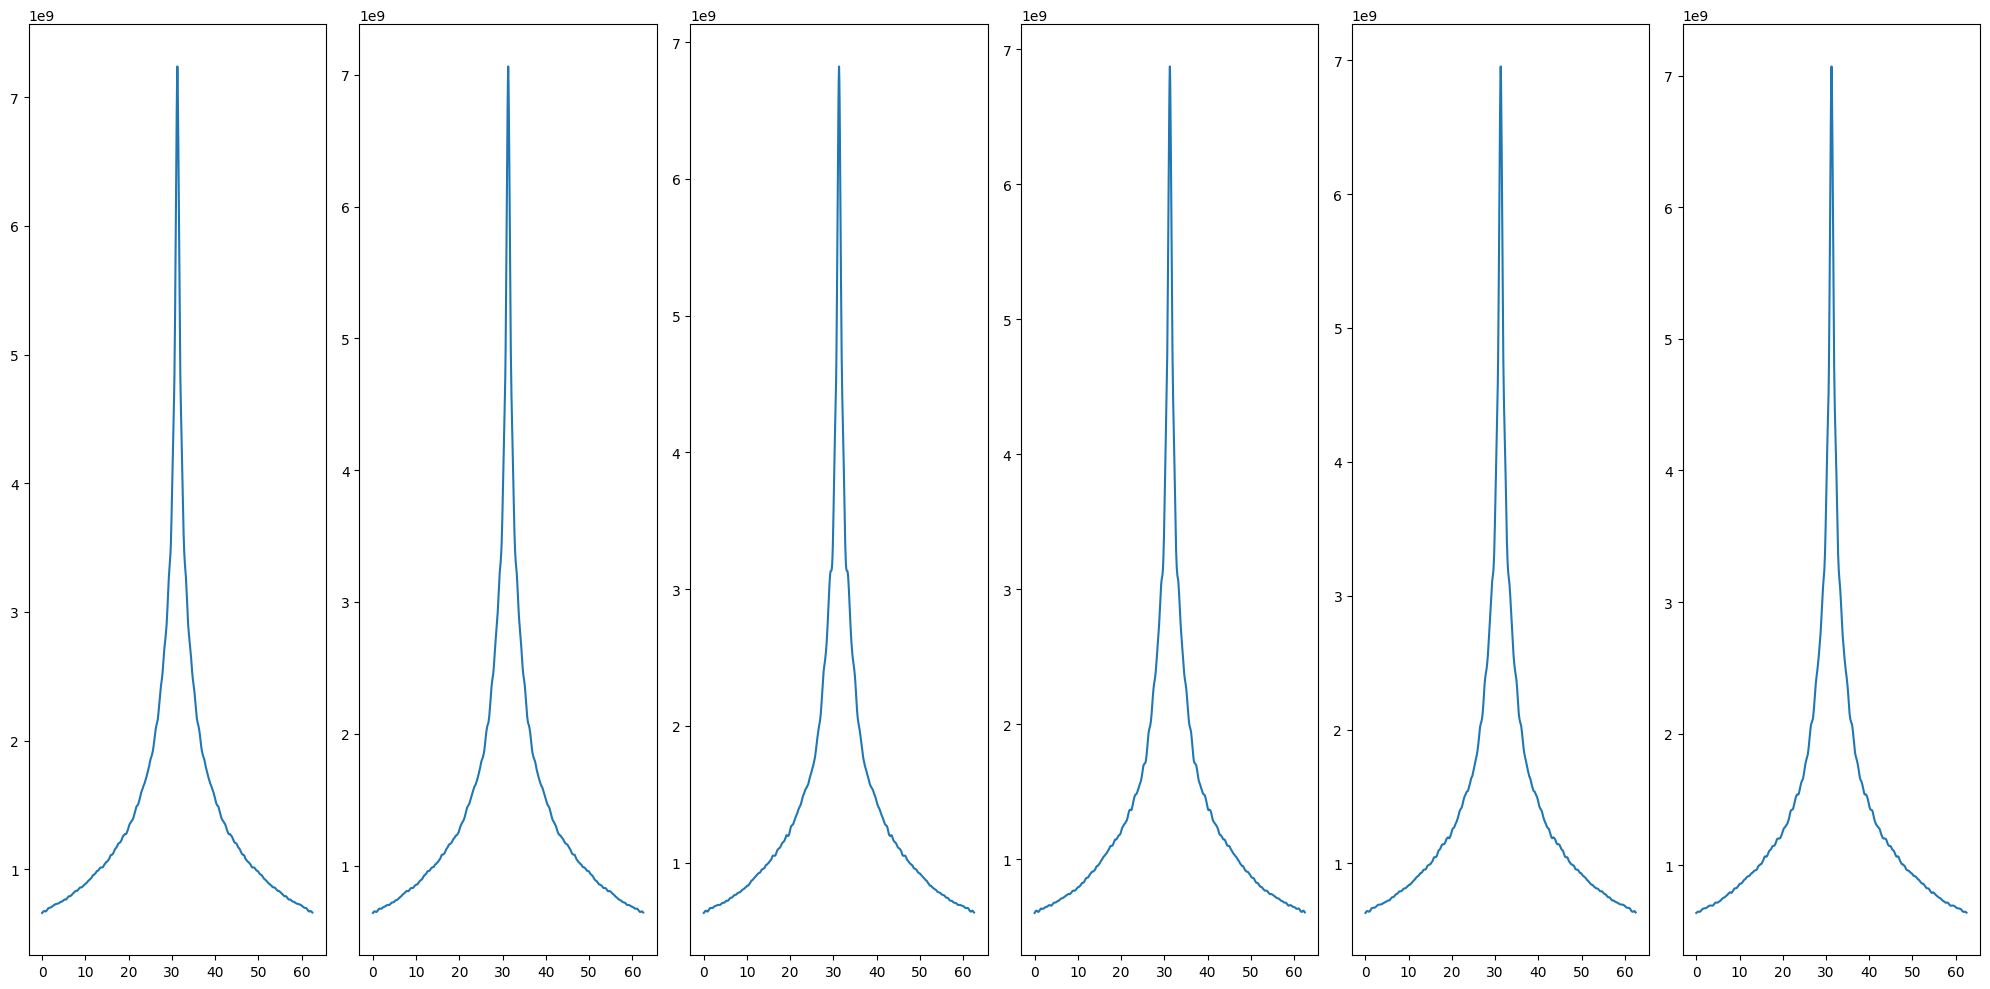

In [7]:
from scipy.signal import correlate

mean_freq_by_label = {}

for label in labels:
    mean_freq_by_label[label] = np.mean(freq_matrix[:, :, label_session_map[:, 0] == label], axis=2)

fig, axes = plt.subplots(1, 6, figsize=(20, 10))
for i, (label, label_mean_freq_matrix) in enumerate(mean_freq_by_label.items()):
    self_correlation = correlate(label_mean_freq_matrix[:, 0], label_mean_freq_matrix[:, 0], mode='same')
    axes[i].plot(signal_freq, self_correlation, label=label)
    # axes[i].set_title(f'Channel {j}')
# plt.colorbar()
plt.tight_layout()
plt.show()

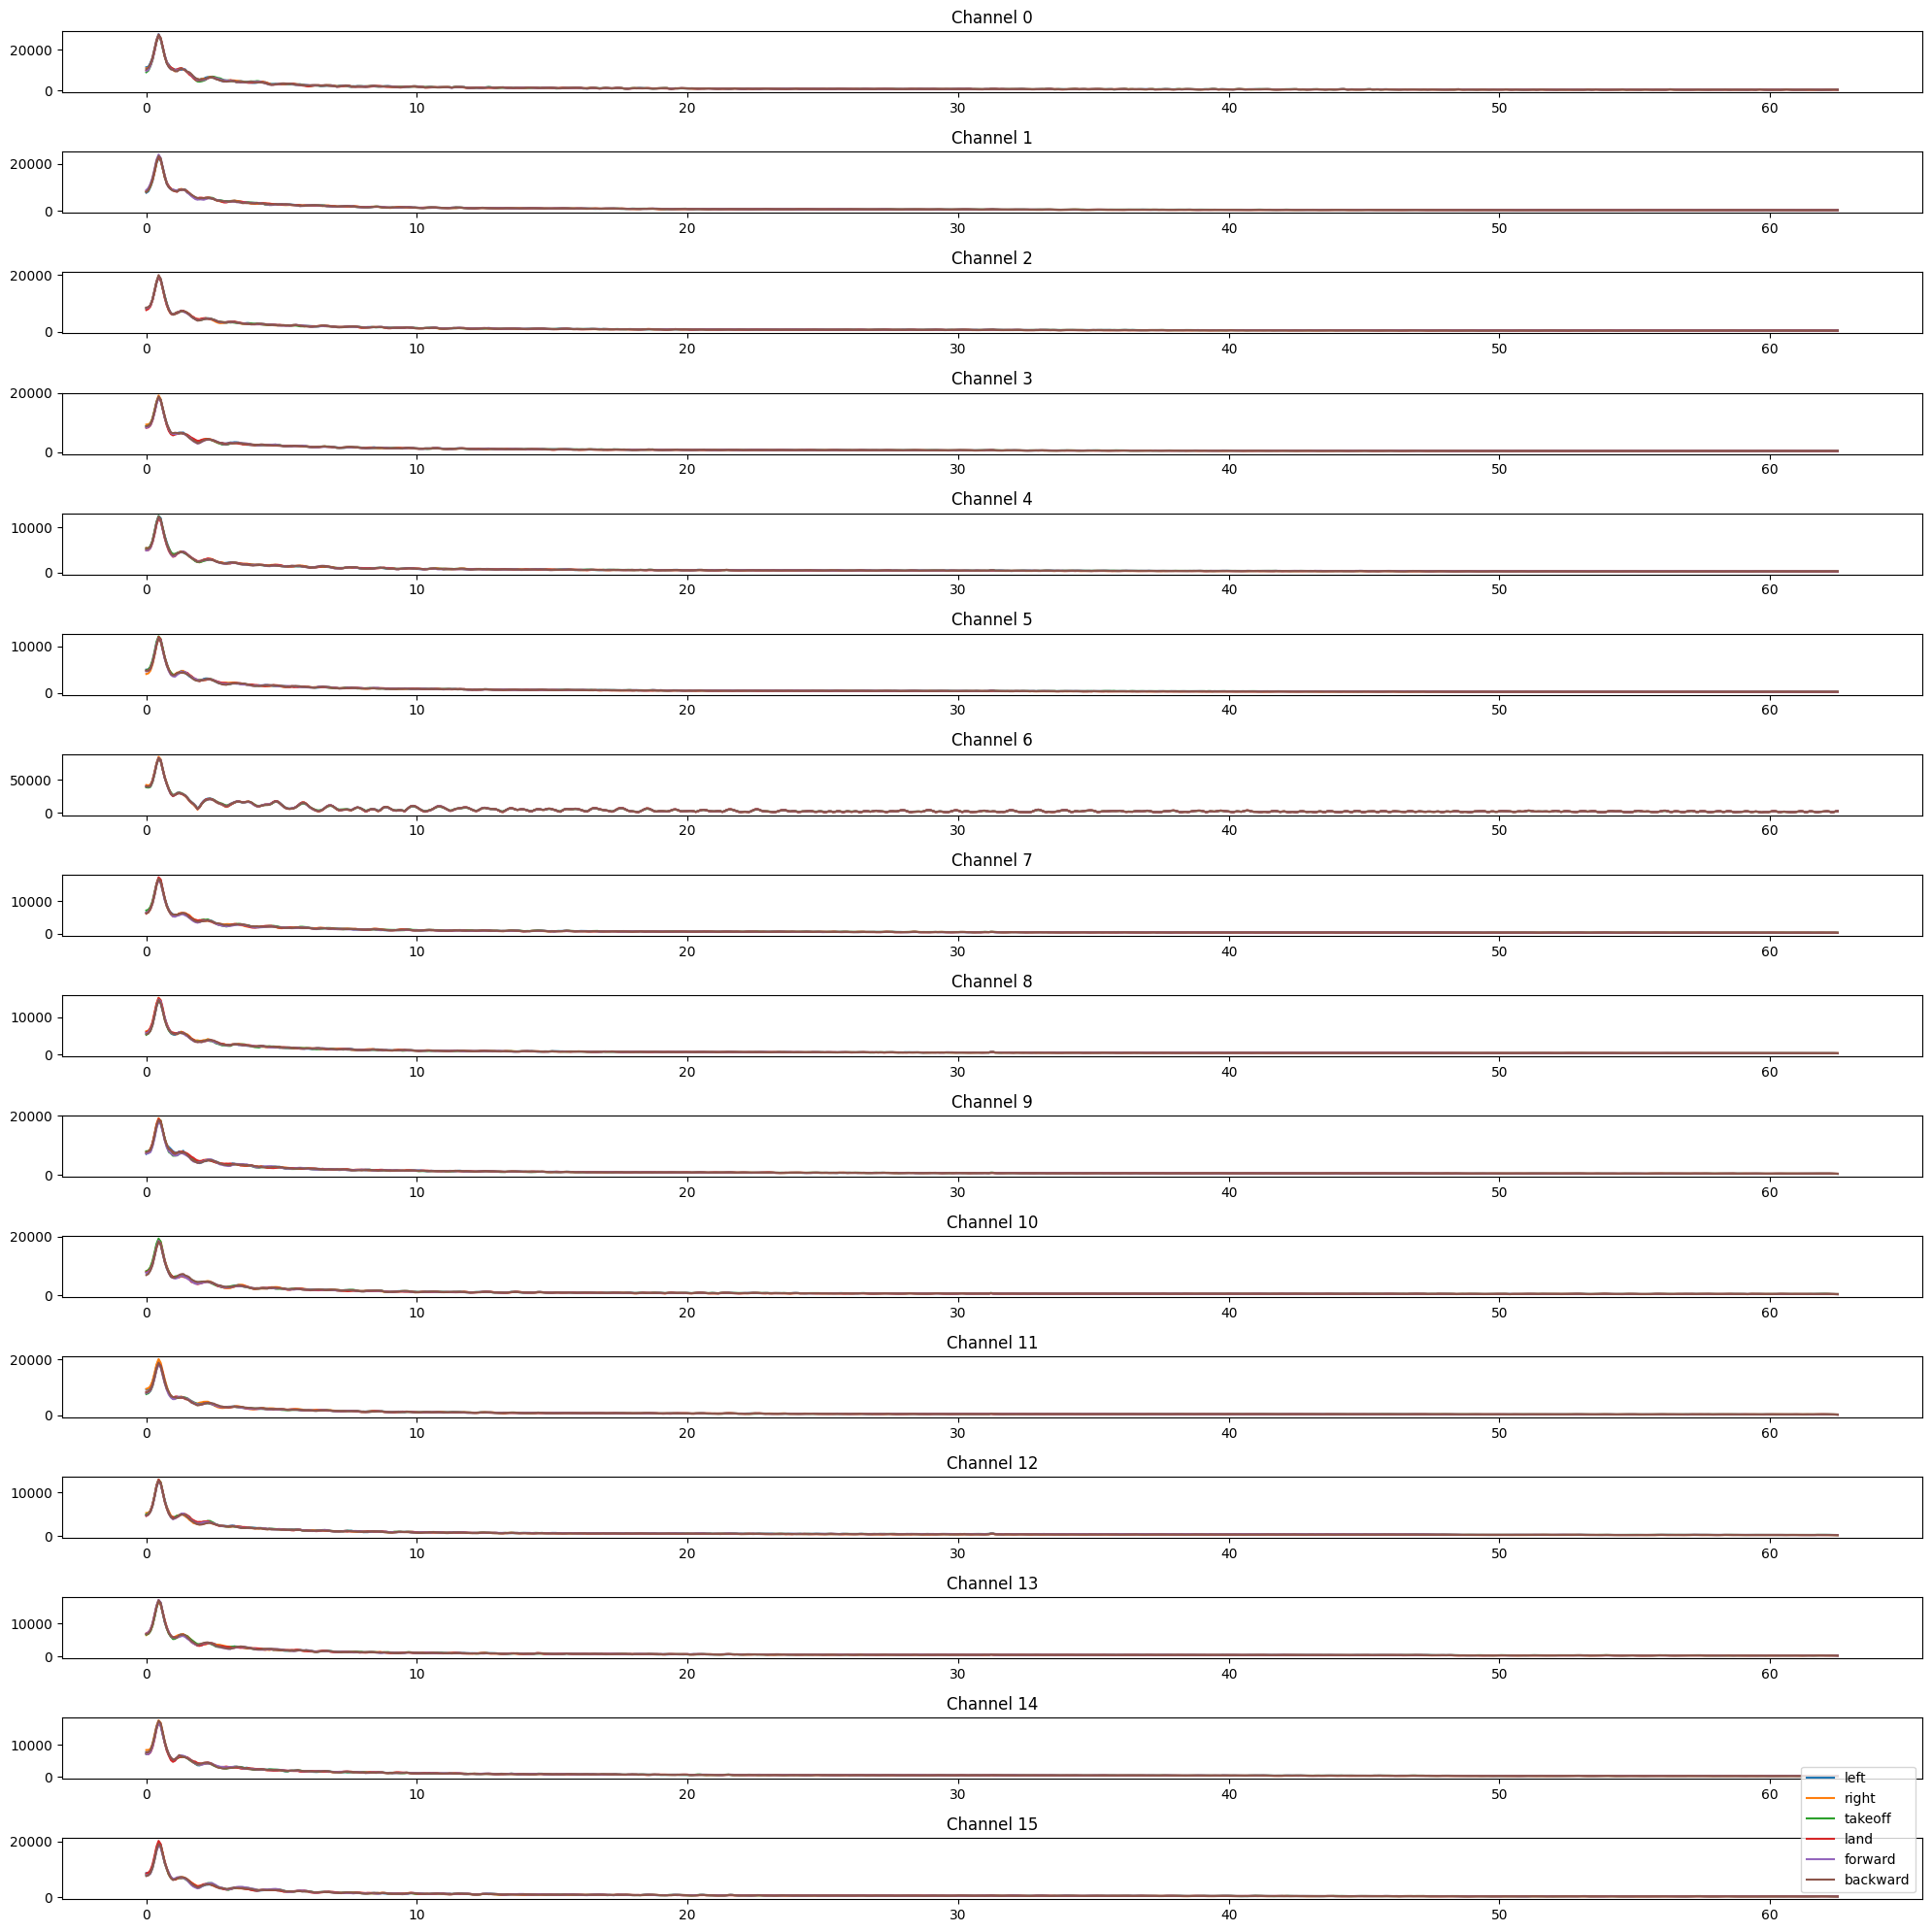

In [8]:
fig, axes = plt.subplots(freq_matrix.shape[1], 1, figsize=(20, 20))
for j in range(freq_matrix.shape[1]):
    for label, label_mean_freq_matrix in mean_freq_by_label.items():
        axes[j].plot(signal_freq, label_mean_freq_matrix[:, j], label=label)
        axes[j].set_title(f'Channel {j}')
plt.tight_layout()
plt.legend()
plt.show()

## Model Training
Testing GroupKFold first
Raw channel data

In [9]:
def split_on_trial():
    saved_trials = pd.DataFrame(columns=['label', 'trial'])
    for label, group in df.groupby('label', sort=False):
        # select 10% of the trials to take out of the training set
        label_trials_to_take_out = pd.DataFrame(columns=['label', 'trial'])
        label_trials_to_take_out['trial'] = group.trial.drop_duplicates().sample(frac=0.1, random_state=42)
        label_trials_to_take_out['label'] = label
        saved_trials = pd.concat([saved_trials, label_trials_to_take_out])
    return saved_trials


def split_on_session():
    saved_trials = pd.DataFrame(columns=['label', 'trial'])
    for label, group in df.groupby('label', sort=False):
        # select 10% of the trials to take out of the training set
        sessions_to_take_out = group.session.drop_duplicates().sample(frac=0.1, random_state=42)
        session_trials_to_take_out = pd.DataFrame(columns=['label', 'trial'])
        session_trials_to_take_out['trial'] = group[group.session.isin(sessions_to_take_out)].trial.drop_duplicates()
        session_trials_to_take_out['label'] = label
        saved_trials = pd.concat([saved_trials, session_trials_to_take_out])
    return saved_trials


def train_test_split(dataframe, split_on: str = 'trial'):
    if split_on == 'trial':
        saved_trials = split_on_trial()
    elif split_on == 'session':
        saved_trials = split_on_session()
    else:
        raise ValueError('split_on must be either "trial" or "session"')

    training_set = dataframe[~dataframe.trial.isin(saved_trials.trial)]
    testing_set = dataframe[dataframe.trial.isin(saved_trials.trial)]

    return training_set, testing_set

In [10]:
from scipy.fft import rfft, rfftfreq, next_fast_len


def make_freq_df(dataframe, cols):
    max_trial_len = dataframe.groupby('trial', sort=False).size().max()
    n = next_fast_len(max_trial_len)

    signal_freq = rfftfreq(n, d=1 / 125)
    trial_dfs = []
    for trial, group in dataframe.groupby('trial', sort=False):
        trial_df = pd.DataFrame()
        trial_data = group[cols].to_numpy(copy=True)
        signal_fft = rfft(trial_data, n, axis=0)
        trial_df['freq'] = signal_freq
        trial_df[cols] = np.abs(signal_fft)
        trial_df['trial'] = trial
        trial_df['label'] = group['label'].iloc[0]
        trial_df['session'] = group['session'].iloc[0]
        trial_dfs.append(trial_df)
    freq_df = pd.concat(trial_dfs, ignore_index=True)
    return freq_df


In [19]:
from sklearnex.ensemble import RandomForestClassifier

from sklearn.model_selection import GroupKFold, cross_validate
from mlxtend.evaluate import GroupTimeSeriesSplit

df.sort_values(by=['session', 'trial', ' Timestamp'], inplace=True)

filtered_df = df
# filtered_df = filter_trials(df)
# filtered_df = remove_outliers(filtered_df)
# filtered_df = make_freq_df(filtered_df, cols)

training_set, testing_set = train_test_split(filtered_df, split_on='session')

X = training_set[cols].to_numpy().astype(np.float64)
y = training_set['label'].map(lambda x: labels.index(x)).to_numpy()
groups = training_set['session'].to_numpy()

In [20]:
# gkf = GroupKFold(n_splits=5)
gkf = GroupTimeSeriesSplit(test_size=20, n_splits=10)
clf = RandomForestClassifier(n_estimators=50, random_state=42)
scoring = {'accuracy': 'accuracy'}
cv_results = cross_validate(clf, X, y, groups=groups, cv=gkf, scoring=scoring, return_train_score=True, verbose=2,
                            n_jobs=-1, return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.8min remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


In [21]:
cv_results

{'fit_time': array([50.84137535, 50.24893141, 55.59524632, 52.95170736, 52.98957539,
        51.62663436, 51.31525135, 54.06204128, 54.81950378, 51.84085202]),
 'score_time': array([2.07418919, 1.07419181, 6.34260297, 5.74362755, 6.33230495,
        4.28152347, 5.56411457, 6.5552969 , 6.82407761, 5.49251533]),
 'estimator': [RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42),
  RandomForestClassifier(n_estimators=50, random_state=42)],
 'test_accuracy': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix

estimators = cv_results['estimator']
test_X = testing_set[cols].to_numpy().astype(np.float64)
test_y = testing_set['label'].map(lambda x: labels.index(x)).to_numpy()

y_pred = np.zeros((test_X.shape[0], len(estimators)))
accuracy = np.zeros(len(estimators))
for i, estimator in enumerate(estimators):
    y_pred[:, i] = estimator.predict(test_X)
    accuracy[i] = accuracy_score(test_y, y_pred[:, i])

accuracy

INFO:sklearnex: sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: skle

array([2.05685677e-04, 8.75258201e-06, 2.80082624e-04, 1.40916570e-02,
       5.63666282e-03, 1.31288730e-05, 4.37629101e-06, 1.75051640e-05,
       1.31288730e-05, 1.39166054e-03])